In [1]:
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 9.3 MB/s eta 0:00:00


In [ ]:
pip install fitz

In [7]:

pip install pip install PyMuPDF==1.19.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 15.5 MB/s eta 0:00:00


In [78]:
pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.7 MB/s eta 0:00:00


In [ ]:
!pip -m spacy download es_core_news_sm

# Notebook creado en google collab

In [ ]:
import boto3
import fitz
from PIL import Image
import io
from IPython.display import display, Image as IPImage
from unidecode import unidecode
import re
from dateutil import parser
from datetime import datetime
import json

In [29]:
# Hay que ingresar los credenciales para acceder a AWS y al modelo textract
# Estos credenciales se crean en la cuenta de AWS en claves de acceso
# Por seguridad los credenciales fueron borrados del siguiente codigo.
client = boto3.client('textract',region_name='us-east-1',aws_access_key_id='',aws_secret_access_key='')

In [321]:
def extraer_data(archivo_):
  """
  Solo se admiten archivos pdf, y json.
  Esta funcion extrae los valores del numero de matricula, la fecha, la jurisdiccion y el estado del folio de un archivo pdf o un json.
  """
  nombre_archivo = archivo_
  extension = nombre_archivo.split(".")[-1]

  if extension.lower() == "pdf":

    pdf_path = archivo_ # se carga la ruta del pdf que se encuentra en los archivos de google collab

    # Se abre el archivo PDF
    pdf_document = fitz.open(pdf_path)

    # Se obtiene la primera pagina del PDF para analizar, en este caso siempre se analizara la primera hoja pero se puede cambiar.
    page = pdf_document[0] 

    # Convierte la página del PDF en una imagen
    image = page.get_pixmap()

    image_pil = Image.frombytes("RGB", (image.width, image.height), image.samples) # Se crea la imagen de la primera hoja del pdf en escala de colores = "RGB" o en grises = "L"
    image_path = "/content/output_image.png" # se le asigna un nombre al Path
    image_pil.save(image_path) # se guarda la imagen
    # Cierra el documento PDF
    pdf_document.close()
    # image_pil # para ver la imagen se imprime esta linea

    with open('/content/output_image.png', 'rb') as image:
      img = bytearray(image.read())
    response = client.detect_document_text(Document={'Bytes': img})
  
    df = response.copy()
  else:
    guestfile = open(archivo_, "r")
    guestdata = guestfile.read()
    guestfile.close()
    df = json.loads(guestdata)

  ################################# Empieza el codigo para obtener el texto ###################################################

  text = ""
  frase = []

  for item in df["Blocks"]:
      if item["BlockType"] == "LINE":
          # Obtener el texto de la línea y quitar las tildes
          linea = unidecode(item['Text'])

          # Palabras específicas que deseas buscar en las oraciones
          palabras_objetivo = ["nro matricula", "impreso", "depto", "municipio", "VEREDA", "activo", "inactivo"]

          # Comprobar si la línea contiene alguna de las palabras objetivo
          if any(re.search(re.escape(palabra), linea, flags=re.IGNORECASE) for palabra in palabras_objetivo):
              frase.append(linea)

########################################### Se obtiene el numero de matricula #############################
  nro_matricula = frase[0].split()[-1]
########################################### se obtiene el numero de folio ################################
  folio = frase[3].split()[-1]
#################################### se obtiene las jurisdicciones ###################################3
  frase2 = frase[2].upper()

  # Patrones de expresiones regulares, se busca la primera palabra despues de DPTO, MUNICIPIO o VEREDA
  patron_depto = r"DEPTO ([^\s]+)"
  patron_municipio = r"MUNICIPIO ([^\s]+)"
  patron_vereda = r"VEREDA ([^\s]+)"

  # Se eliminan las tildes de la frase
  frase_sin_tildes = unidecode(frase2)

  # Se reemplazan los dos puntos ":" por un espacio en blanco " "
  frase_sin_dos_puntos = frase_sin_tildes.replace(':', '')

  # Se buscan patrones en la frase
  match_depto = re.search(patron_depto, frase_sin_dos_puntos)
  match_municipio = re.search(patron_municipio, frase_sin_dos_puntos)
  match_vereda = re.search(patron_vereda, frase_sin_dos_puntos)

  # Se obtienen los resultados, si no hay coincidencia es None
  depto = match_depto.group(1) if match_depto else None
  municipio = match_municipio.group(1) if match_municipio else None
  vereda = match_vereda.group(1) if match_vereda else None

######################################################### FECHA #######################################################

  cadena_fecha = frase[1]

  # Diccionario de mapeo de nombres de meses a numeros
  meses_dict = {
      'enero': '01',
      'febrero': '2',
      'marzo': '03',
      'abril': '04',
      'mayo': '05',
      'junio': '06',
      'julio': '07',
      'agosto': '08',
      'septiembre': '09',
      'octubre': '10',
      'noviembre': '11',
      'diciembre': '12'
  }

  # Funcion para convertir el nombre del mes a su equivalente numerico
  def convertir_mes_a_numero(mes):
      return meses_dict.get(mes.lower(), mes)

  # Se separa la cadena en palabras
  palabras = cadena_fecha.split()

  # Encontrar la posicion del nombre del mes en la cadena
  posicion_mes = palabras.index('de') + 1

  # Se convierte el nombre del mes a su equivalente numerico
  palabras[posicion_mes] = convertir_mes_a_numero(palabras[posicion_mes])

  # Se reunen las palabras de nuevo en una cadena
  cadena_fecha_modificada = ' '.join(palabras)

  # Se extraen los numeros usando expresiones regulares
  numeros_extraidos = re.findall(r'\b\d+\b', cadena_fecha_modificada)

  # Se convierten los numeros a enteros
  numeros_enteros = [int(num) for num in numeros_extraidos]
  numeros_fecha = numeros_enteros[0:3]
  fecha = datetime(numeros_fecha[2], numeros_fecha[1], numeros_fecha[0]).strftime("%Y/%m/%d")

##################################### RESULTADOS ######################################################3333

  # Imprimir los resultados
  print("NRO MATRICULA:", nro_matricula)
  print("FECHA:", fecha)
  print("DEPTO:", depto)
  print("Municipio:", municipio)
  print("Vereda:", vereda)
  print('ESTADO DEL FOLIO:', folio)


In [323]:
extraer_data("/content/040-464031-220204640254303951_pag1.json")

NRO MATRICULA: 040-464031
FECHA: 2022/02/04
DEPTO: ATLANTICO
Municipio: BARRANQUILLA
Vereda: BARRANQUILLA
ESTADO DEL FOLIO: ACTIVO


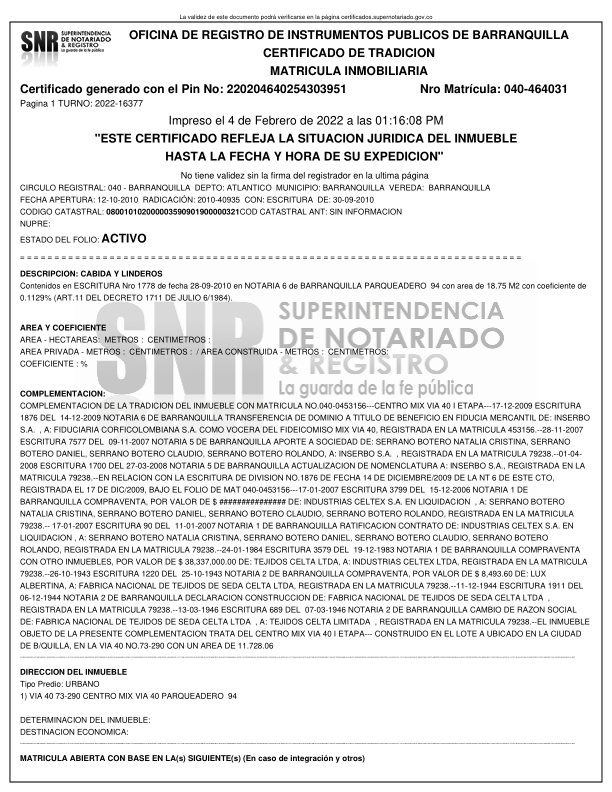

In [25]:
image_pil # para ver la imagen se imprime esta linea